In [2]:
# from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import (
    ggplot,
    aes,
    geom_boxplot,
    scale_x_discrete,
    ggtitle
)
import os

from os import path
from wordcloud import WordCloud

In [3]:
# Load patients data
# d1 = files.upload()
patients = pd.read_csv('../mimic-iii-clinical-database-demo-1.4/PATIENTS.csv')
patients.head(3)

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1
2,9474,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1


In [4]:
# Load admissions data
# d2 = files.upload()
admissions = pd.read_csv('../mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv')
admissions.head(3)

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1


## Patients Table

In [5]:
from datetime import datetime
df = patients
# Calculate age function
def calculate_age(dob, dod):
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    dod_date = datetime.strptime(dod, "%Y-%m-%d %H:%M:%S")
    age = (dod_date - dob_date).days // 365
    return age

# Apply calculate_age function to create "age" column
df["age"] = df.apply(lambda row: calculate_age(row["dob"], row["dod"]), axis=1)

# Filter out rows with age greater than or equal to 120
filtered_df = df[df["age"] < 120]

# Display the updated DataFrame
print(filtered_df.head())

   row_id  subject_id gender                  dob                  dod  \
0    9467       10006      F  2094-03-05 00:00:00  2165-08-12 00:00:00   
1    9472       10011      F  2090-06-05 00:00:00  2126-08-28 00:00:00   
2    9474       10013      F  2038-09-03 00:00:00  2125-10-07 00:00:00   
3    9478       10017      F  2075-09-21 00:00:00  2152-09-12 00:00:00   
4    9479       10019      M  2114-06-20 00:00:00  2163-05-15 00:00:00   

              dod_hosp              dod_ssn  expire_flag  age  
0  2165-08-12 00:00:00  2165-08-12 00:00:00            1   71  
1  2126-08-28 00:00:00                  NaN            1   36  
2  2125-10-07 00:00:00  2125-10-07 00:00:00            1   87  
3                  NaN  2152-09-12 00:00:00            1   77  
4  2163-05-15 00:00:00  2163-05-15 00:00:00            1   48  


## Patients and Admissions Table

In [6]:
# Merge admissions and patients data on subject_id
merged_data = pd.merge(admissions, filtered_df, on="subject_id")
print(merged_data.head(1))

   row_id_x  subject_id  hadm_id            admittime            dischtime  \
0     12258       10006   142345  2164-10-23 21:09:00  2164-11-01 17:15:00   

  deathtime admission_type    admission_location discharge_location insurance  \
0       NaN      EMERGENCY  EMERGENCY ROOM ADMIT   HOME HEALTH CARE  Medicare   

   ... hospital_expire_flag has_chartevents_data row_id_y gender  \
0  ...                    0                    1     9467      F   

                   dob                  dod             dod_hosp  \
0  2094-03-05 00:00:00  2165-08-12 00:00:00  2165-08-12 00:00:00   

               dod_ssn  expire_flag  age  
0  2165-08-12 00:00:00            1   71  

[1 rows x 27 columns]


In [7]:
merged_data['marital_status'].value_counts()

marital_status
MARRIED              57
SINGLE               25
WIDOWED              14
DIVORCED              6
UNKNOWN (DEFAULT)     5
SEPARATED             1
Name: count, dtype: int64

## Vis. 1: Length of life by marital status ... AND gender

In [8]:
# Filter out rows with marital status as "MARRIED" or "SINGLE"

marital_status_main = ["MARRIED", "SINGLE"]

marital_status_filtered = merged_data.loc[
    merged_data['marital_status'].isin(marital_status_main)
]

# Display the updated DataFrame value counts
marital_status_filtered['marital_status'].value_counts()

marital_status
MARRIED    57
SINGLE     25
Name: count, dtype: int64

In [9]:
marital_status_filtered['marital_status'].value_counts()

marital_status
MARRIED    57
SINGLE     25
Name: count, dtype: int64

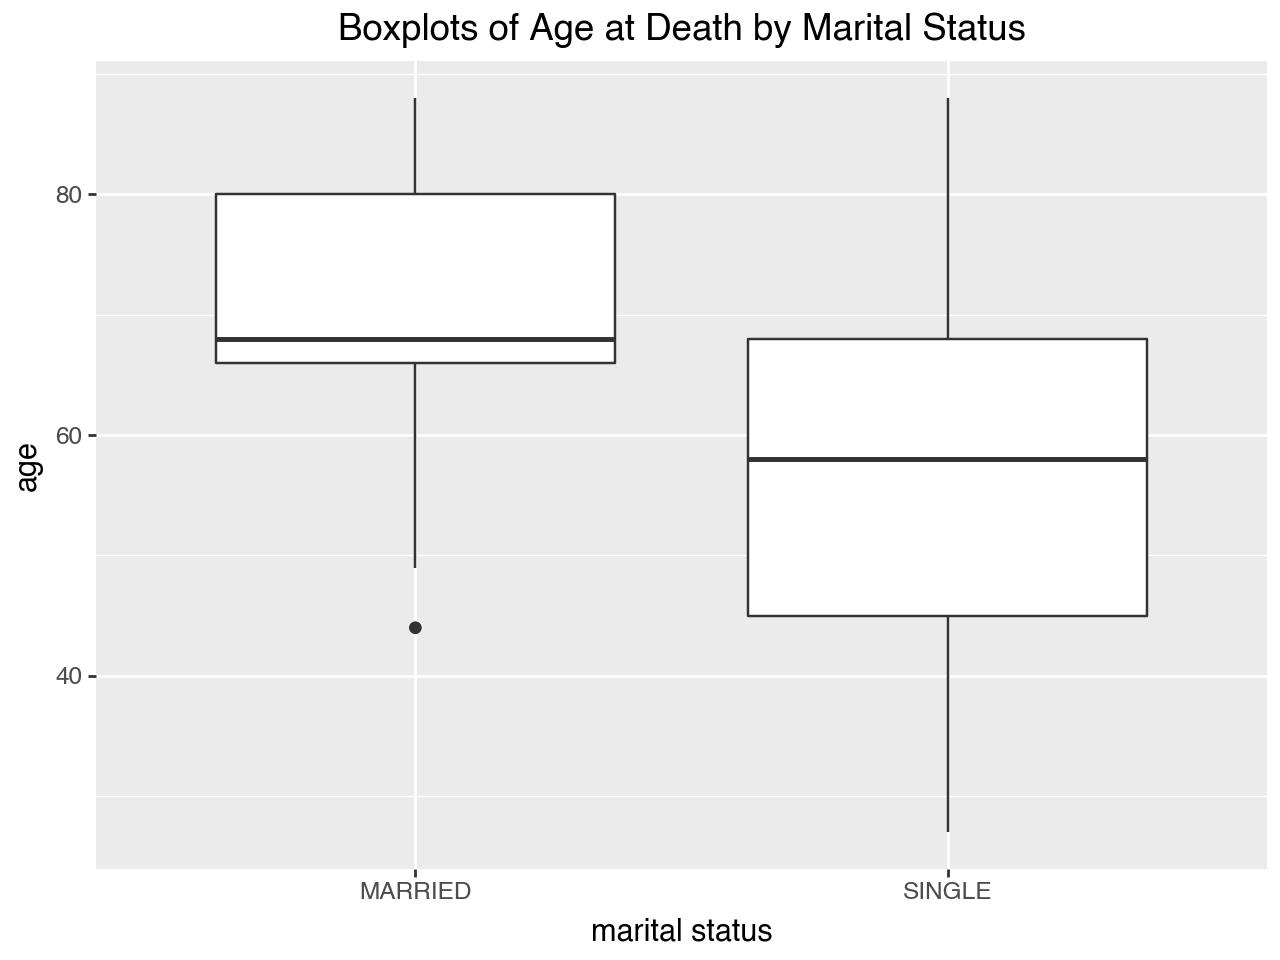

In [10]:
from plotnine import (
    ggplot,
    aes,
    geom_boxplot,
    scale_x_discrete,
    ggtitle
)

# Filter out rows with marital status as "MARRIED" or "SINGLE"
marital_status_main = ["MARRIED", "SINGLE"]

marital_status_filtered = merged_data.loc[
    merged_data['marital_status'].isin(marital_status_main)
]

# Boxplots of age at death by marital status
(
    ggplot(marital_status_filtered)
    + geom_boxplot(aes(x="factor(marital_status)", y="age"))
    + ggtitle(title="Boxplots of Age at Death by Marital Status", subtitle=None)
    + scale_x_discrete(labels=marital_status_main, name="marital status") 
)

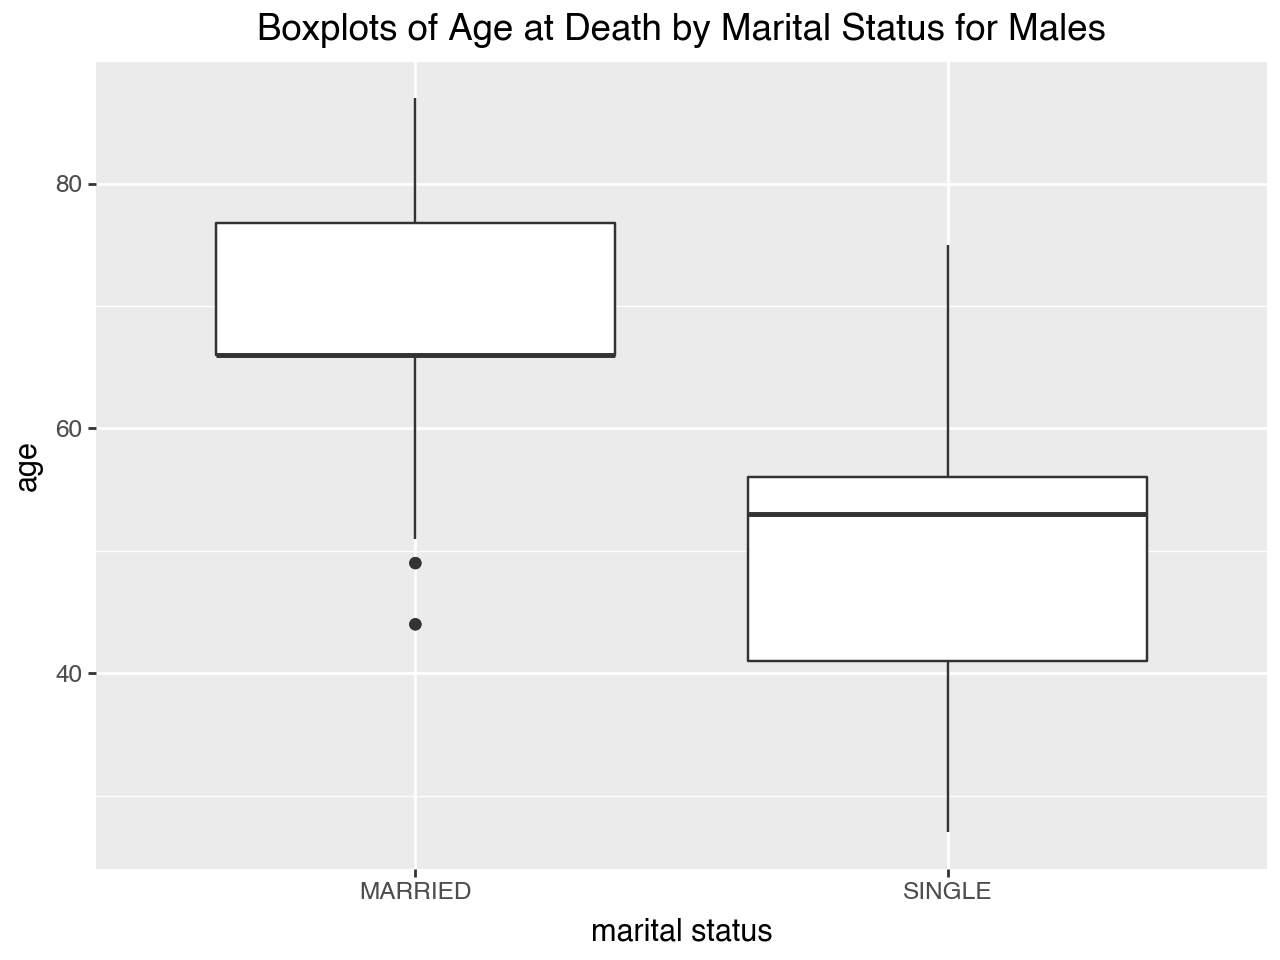

In [11]:
# Now lets revise this analysis by analysis by considering just the males
marital_status_males = marital_status_filtered.loc[marital_status_filtered['gender'] == 'M']

# Boxplots of age at death by marital status
(
    ggplot(marital_status_males)
    + geom_boxplot(aes(x="factor(marital_status)", y="age"))
    + ggtitle(title="Boxplots of Age at Death by Marital Status for Males", subtitle=None)
    + scale_x_discrete(labels=marital_status_main, name="marital status") 
)

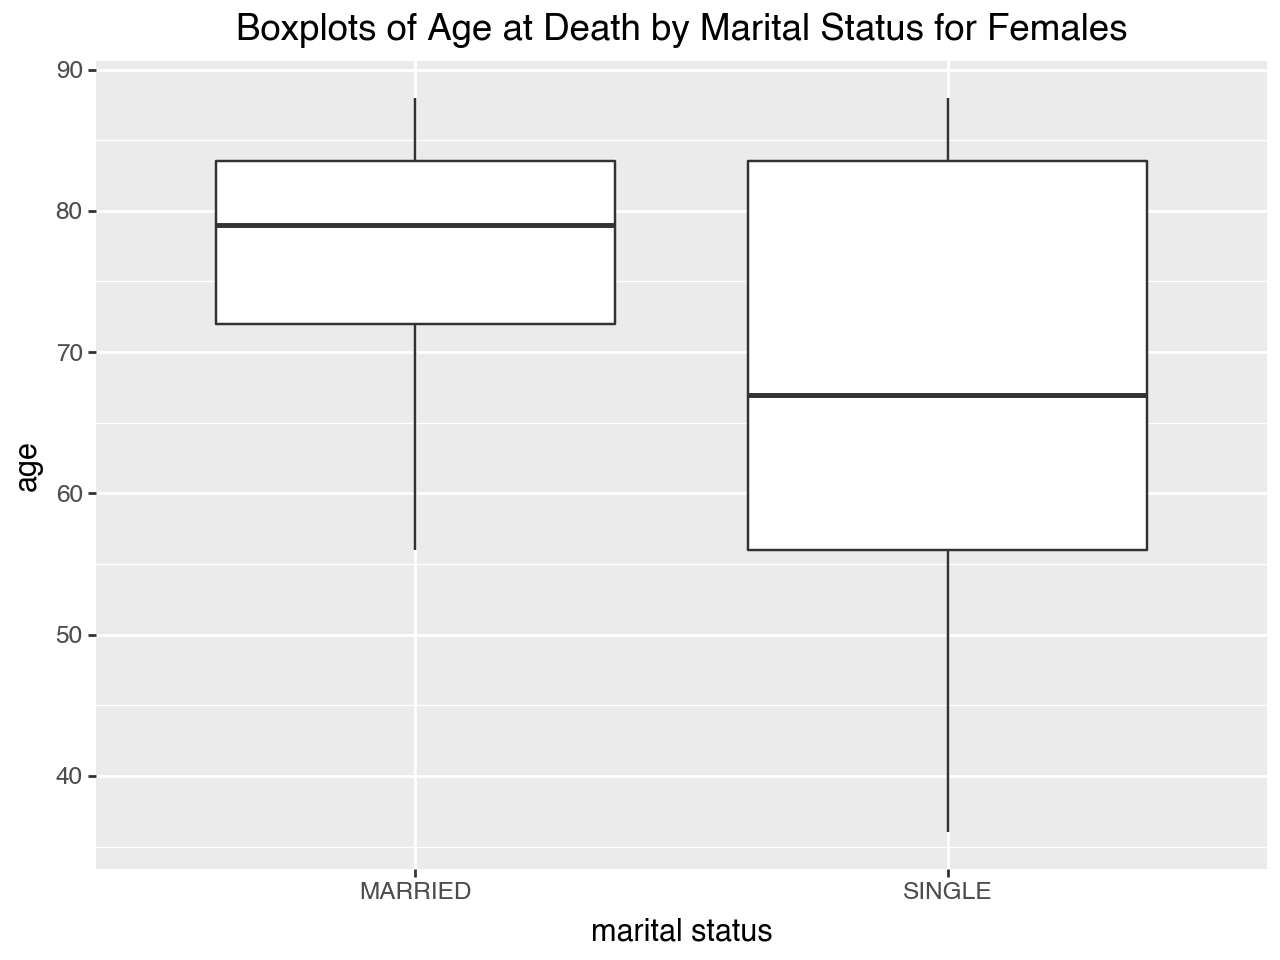

In [12]:
# Now lets revise this analysis by analysis by considering just the females
marital_status_females = marital_status_filtered.loc[marital_status_filtered['gender'] == 'F']

# Boxplots of age at death by marital status
(
    ggplot(marital_status_females)
    + geom_boxplot(aes(x="factor(marital_status)", y="age"))
    + ggtitle(title="Boxplots of Age at Death by Marital Status for Females", subtitle=None)
    + scale_x_discrete(labels=marital_status_main, name="marital status") 
)

## Vis. 2: Prescription Word Cloud

drug
Potassium Chloride              529
D5W                             439
0.9% Sodium Chloride            409
NS                              362
Furosemide                      346
                               ... 
Viokase-8                         1
Hyoscyamine                       1
MetFORMIN XR (Glucophage XR)      1
Pioglitazone HCl                  1
0.83% Sodium Chloride             1
Name: count, Length: 592, dtype: int64


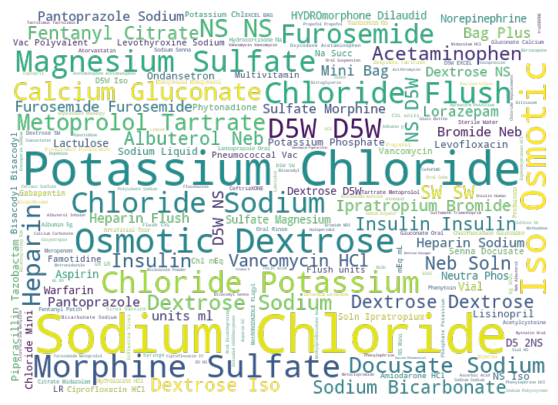

In [13]:
import matplotlib.pyplot as plt
import os
from os import path
from wordcloud import WordCloud

# Load perscriptions data
perscriptions = pd.read_csv(
    '../mimic-iii-clinical-database-demo-1.4/PRESCRIPTIONS.csv'
    )

# Too many drugs: which most commonly used?
print(perscriptions['drug'].value_counts())

# Create a wordcloud object
wordcloud = WordCloud(
    width = 700,
    height = 500,
    mode="RGBA",  # Set mode to RGBA for transparency
    background_color=None,  # For transparency
).generate(' '.join(perscriptions['drug']))

# Plot
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Vis. 3: Respiratory Rates vs. Heart Rates

In [14]:
# Load chart events data
chartevents = pd.read_csv('../mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv')
chartevents.head(3)

/var/folders/tv/tlhld7_50x99sr4fjlkkq83w0000gp/T/ipykernel_19680/1440838816.py:2: DtypeWarning: Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.


,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,5279021,40124,126179,279554.0,223761,2130-02-04 04:00:00,2130-02-04 04:35:00,19085,95.9,95.9,?F,0.0,0.0,NaN,NaN
1,5279022,40124,126179,279554.0,224695,2130-02-04 04:25:00,2130-02-04 05:55:00,18999,2222221.7,2222221.7,cmH2O,0.0,0.0,NaN,NaN
2,5279023,40124,126179,279554.0,220210,2130-02-04 04:30:00,2130-02-04 04:43:00,21452,15.0,15.0,insp/min,0.0,0.0,NaN,NaN


In [15]:
# Filter out rows with itemid equal to 220045 (heart rates)
heartrates = chartevents[chartevents["itemid"] == 220045]
heartrates.head(3)

,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
3,5279024,40124,126179,279554.0,220045,2130-02-04 04:32:00,2130-02-04 04:43:00,21452,94.0,94.0,bpm,0.0,0.0,NaN,NaN
21,5279042,40124,126179,279554.0,220045,2130-02-04 05:01:00,2130-02-04 05:33:00,21452,88.0,88.0,bpm,0.0,0.0,NaN,NaN
24,5279045,40124,126179,279554.0,220045,2130-02-04 06:00:00,2130-02-04 06:08:00,21452,82.0,82.0,bpm,0.0,0.0,NaN,NaN


In [16]:
# How many subjects are there?
heartrates['subject_id'].value_counts()

subject_id
41976    1135
44212     782
42367     708
40310     672
42135     548
42281     486
42075     413
41914     320
41795     292
40595     264
44083     196
43798     185
40124     157
42066     132
42199     131
43748     119
44228     118
43746      98
43881      92
40612      91
43735      83
42430      74
40601      61
40286      59
43827      56
42321      56
42346      56
40177      55
40304      54
40456      47
41983      45
43927      44
42412      41
43870      39
40687      37
44222      34
44154      32
40277      31
42231      27
42033      26
43879      25
42292      25
40503      24
42302      23
42458      23
40204      20
42275      19
43779      18
40655      17
43909       4
Name: count, dtype: int64

In [17]:
# Subjects with 25 heart rate recordings:
# 43879      25
# 42292      25
# Let's extract their heart rate data for a 2 sample t-test

# Filter out rows with subject_id == 43879
heartrates43879 = heartrates[heartrates["subject_id"] == 43879]
print(heartrates43879.head(3))

# Filter out rows with subject_id == 42292
heartrates42292 = heartrates[heartrates["subject_id"] == 42292]
print(heartrates42292.head(3))

        row_id  subject_id  hadm_id  icustay_id  itemid            charttime  \
79330  7346143       43879   158100    264258.0  220045  2106-08-30 15:45:00   
79343  7346156       43879   158100    264258.0  220045  2106-08-30 15:49:00   
79349  7346162       43879   158100    264258.0  220045  2106-08-30 15:51:00   

                 storetime   cgid value  valuenum valueuom  warning  error  \
79330  2106-08-30 15:50:00  18386   103     103.0      bpm      0.0    0.0   
79343  2106-08-30 15:50:00  18386   101     101.0      bpm      0.0    0.0   
79349  2106-08-30 15:51:00  20951   101     101.0      bpm      0.0    0.0   

      resultstatus stopped  
79330          NaN     NaN  
79343          NaN     NaN  
79349          NaN     NaN  
        row_id  subject_id  hadm_id  icustay_id  itemid            charttime  \
62872  6809912       42292   138503    277238.0  220045  2162-01-16 16:24:00   
62874  6809914       42292   138503    277238.0  220045  2162-01-16 16:30:00   
62889  680

In [18]:
# Filter out rows with itemid equal to 220210 (respiratory rates)
respiratoryrates = chartevents[chartevents["itemid"] == 220210]
respiratoryrates.head(3)

,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
2,5279023,40124,126179,279554.0,220210,2130-02-04 04:30:00,2130-02-04 04:43:00,21452,15.0,15.0,insp/min,0.0,0.0,NaN,NaN
22,5279043,40124,126179,279554.0,220210,2130-02-04 05:01:00,2130-02-04 05:33:00,21452,15.0,15.0,insp/min,0.0,0.0,NaN,NaN
28,5279049,40124,126179,279554.0,220210,2130-02-04 06:00:00,2130-02-04 06:08:00,21452,17.0,17.0,insp/min,0.0,0.0,NaN,NaN


In [19]:
# Filter out rows with subject_id == 43879
respiratoryrates43879 = respiratoryrates[respiratoryrates["subject_id"] == 43879]
respiratoryrates43879['valuenum'].describe()

count    25.000000
mean     16.560000
std       3.267007
min      12.000000
25%      14.000000
50%      16.000000
75%      19.000000
max      23.000000
Name: valuenum, dtype: float64

In [20]:
# Filter out rows with subject_id == 42292
respiratoryrates42292 = respiratoryrates[respiratoryrates["subject_id"] == 42292]
respiratoryrates42292['valuenum'].describe()

count    25.00
mean     16.64
std       1.80
min      13.00
25%      15.00
50%      17.00
75%      18.00
max      20.00
Name: valuenum, dtype: float64

/var/folders/tv/tlhld7_50x99sr4fjlkkq83w0000gp/T/ipykernel_19680/3115467141.py:2: DtypeWarning: Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.


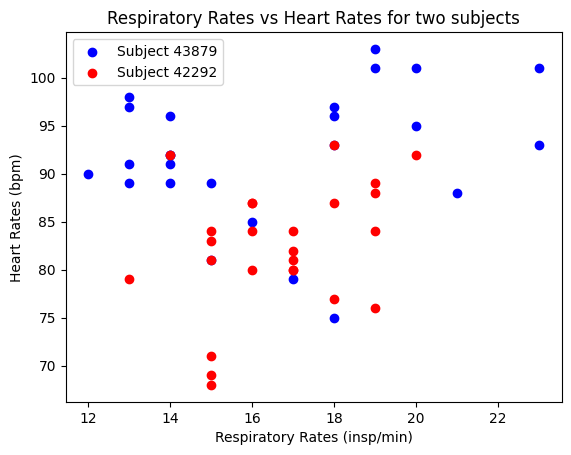

In [44]:
# Load chart events data
chartevents = pd.read_csv(
    '../mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv')

# Filter itemid to 220045 (heart rates), subjects 43879, 42292
heartrates = chartevents[chartevents["itemid"] == 220045]
heartrates43879 = heartrates[heartrates["subject_id"] == 43879]
heartrates42292 = heartrates[heartrates["subject_id"] == 42292]

# Filter itemid to 220210 (respiratory rates), subjects 43879, 42292
respiratoryrates = chartevents[chartevents["itemid"] == 220210]
respiratoryrates43879 = respiratoryrates[respiratoryrates["subject_id"] == 43879]
respiratoryrates42292 = respiratoryrates[respiratoryrates["subject_id"] == 42292]

plt.scatter(respiratoryrates43879['valuenum'], 
            heartrates43879['valuenum'], 
            color='blue', 
            label='Subject 43879')
plt.scatter(respiratoryrates42292['valuenum'], 
            heartrates42292['valuenum'], 
            color='red', 
            label='Subject 42292')

plt.xlabel('Respiratory Rates (insp/min)')
plt.ylabel('Heart Rates (bpm)')
plt.title('Respiratory Rates vs Heart Rates for two subjects')

plt.legend()
plt.show()

## Vis. 4: Comparing two heart rates

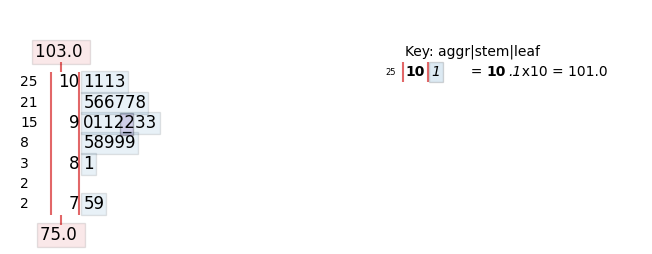

In [32]:
import stemgraphic

# Stem-and-leaf plot for subject 43879
fig, ax = stemgraphic.stem_graphic(heartrates43879['valuenum'])
plt.show()

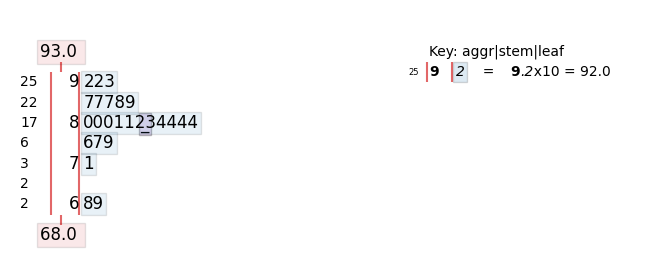

In [33]:
# Stem-and-leaf plot for subject 42292
fig, ax = stemgraphic.stem_graphic(heartrates42292['valuenum'])
plt.show()

## Vis. 5: QQ plots for two sample t-test

In [34]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [35]:
# Standardize data first
# For subject 43879
heartrates43879['valuenum_zscore'] = (heartrates43879['valuenum'] - heartrates43879['valuenum'].mean()) / heartrates43879['valuenum'].std()

# For subject 42292
heartrates42292['valuenum_zscore'] = (heartrates42292['valuenum'] - heartrates42292['valuenum'].mean()) / heartrates42292['valuenum'].std()

/var/folders/tv/tlhld7_50x99sr4fjlkkq83w0000gp/T/ipykernel_19680/425554091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/tv/tlhld7_50x99sr4fjlkkq83w0000gp/T/ipykernel_19680/425554091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
heartrates42292

,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped,valuenum_zscore
62872,6809912,42292,138503,277238.0,220045,2162-01-16 16:24:00,2162-01-16 16:28:00,19593,92.0,92.0,bpm,0.0,0.0,NaN,NaN,1.452836
62874,6809914,42292,138503,277238.0,220045,2162-01-16 16:30:00,2162-01-16 16:28:00,19593,89.0,89.0,bpm,0.0,0.0,NaN,NaN,1.002577
62889,6809929,42292,138503,277238.0,220045,2162-01-16 17:00:00,2162-01-16 16:54:00,19593,92.0,92.0,bpm,0.0,0.0,NaN,NaN,1.452836
62897,6809937,42292,138503,277238.0,220045,2162-01-16 18:00:00,2162-01-16 18:19:00,21304,93.0,93.0,bpm,0.0,0.0,NaN,NaN,1.602922
62921,6809961,42292,138503,277238.0,220045,2162-01-16 19:00:00,2162-01-16 19:16:00,21304,87.0,87.0,bpm,0.0,0.0,NaN,NaN,0.702404
62930,6809970,42292,138503,277238.0,220045,2162-01-16 20:00:00,2162-01-16 20:35:00,16436,77.0,77.0,bpm,0.0,0.0,NaN,NaN,-0.798459
62937,6809977,42292,138503,277238.0,220045,2162-01-16 20:43:00,2162-01-16 20:44:00,16436,80.0,80.0,bpm,0.0,0.0,NaN,NaN,-0.348200
62941,6809981,42292,138503,277238.0,220045,2162-01-16 21:00:00,2162-01-16 22:20:00,16436,80.0,80.0,bpm,0.0,0.0,NaN,NaN,-0.348200
62946,6809986,42292,138503,277238.0,220045,2162-01-16 22:00:00,2162-01-16 22:09:00,16436,82.0,82.0,bpm,0.0,0.0,NaN,NaN,-0.048028
62961,6810001,42292,138503,277238.0,220045,2162-01-16 23:00:00,2162-01-16 23:00:00,16436,81.0,81.0,bpm,0.0,0.0,NaN,NaN,-0.198114


/var/folders/tv/tlhld7_50x99sr4fjlkkq83w0000gp/T/ipykernel_19680/2583317961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


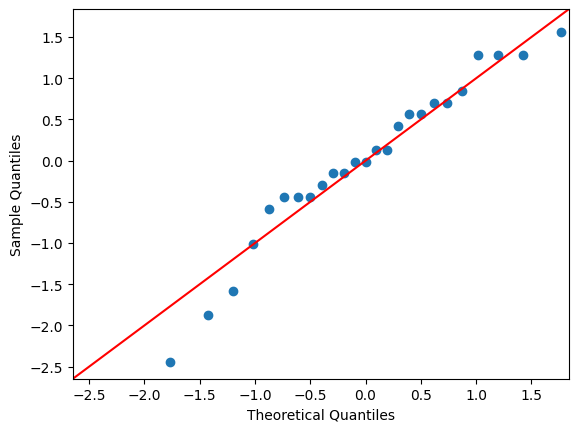

In [48]:
# Standardize data first
# For subject 43879
heartrates43879['valuenum_zscore'] = (heartrates43879['valuenum'] - heartrates43879['valuenum'].mean()) / heartrates43879['valuenum'].std()

# Create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(heartrates43879['valuenum_zscore'], line='45')
plt.show()

/var/folders/tv/tlhld7_50x99sr4fjlkkq83w0000gp/T/ipykernel_19680/2398124741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


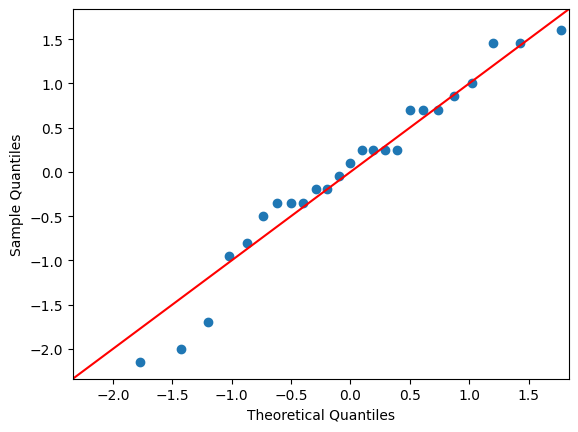

In [46]:
# Standardize data first
# For subject 42292
heartrates42292['valuenum_zscore'] = (heartrates42292['valuenum'] - heartrates42292['valuenum'].mean()) / heartrates42292['valuenum'].std()

# Create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(heartrates42292['valuenum_zscore'], line='45')
plt.show()

## Bonus Vis.: Two sample t-test statistic

TtestResult(statistic=-2.700559028936093e-15, pvalue=0.9999999999999978, df=48.0)


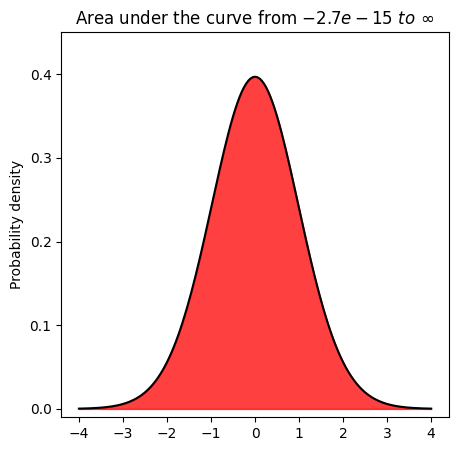

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Perform the two sample t-test with equal variances
print(stats.ttest_ind(a=heartrates43879['valuenum_zscore'], 
                b=heartrates42292['valuenum_zscore'], 
                equal_var=True))

# Plot the PDF
df = 48.0 # Degrees of freedom
x = np.arange(-4, 4.01, 0.05)
yy = stats.t.pdf(x, df)
plt.figure(figsize=(5, 5))
plt.title("Area under the curve from $-2.7e-15 \ to \ \infty$")
plt.plot(x, yy, color="black")
plt.ylim(-0.01, 0.45)
plt.ylabel("Probability density")

# Fill the area under the curve
plt.fill_between(
    x=x,
    y1=yy,
    where=(x >= -100),
    color="red",
    alpha=0.75,
)

plt.show()